# CMIP ITCZ metrics

# Setup

In [1]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
import xarray as xr
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

import warnings

In [2]:
## some magic to automatically reload my functions before running a new cell
%load_ext autoreload
## %reload_ext autoreload
%autoreload 1
%aimport my_functions

import my_functions as mf

## Figure settings

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160

# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

## Load dictionaries

In [4]:
# Get the last 40 years of the 1% CO2 runs and the corresponding time period in piControl
with open('../pkl_files/period_l40_slice_in_pi.pkl', 'rb') as file:
    period_l40_slice_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_pi.pkl', 'rb') as file:
    period_l40_start_year_in_pi = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_pi.pkl', 'rb') as file:
    period_l40_end_year_in_pi = pkl.load(file)
with open('../pkl_files/start_year_in_pi.pkl', 'rb') as file:
    start_year_in_pi = pkl.load(file)
    
with open('../pkl_files/period_l40_slice_in_co2.pkl', 'rb') as file:
    period_l40_slice_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_start_year_in_co2.pkl', 'rb') as file:
    period_l40_start_year_in_co2 = pkl.load(file)
with open('../pkl_files/period_l40_end_year_in_co2.pkl', 'rb') as file:
    period_l40_end_year_in_co2 = pkl.load(file) 
with open('../pkl_files/start_year_in_co2.pkl', 'rb') as file:
    start_year_in_co2 = pkl.load(file)


# Get each model's variant_id
with open('../pkl_files/variant_id.pkl', 'rb') as file:
    variant_id = pkl.load(file)
    
# Get each model's table_id
with open('../pkl_files/table_id.pkl', 'rb') as file:
    table_id = pkl.load(file)
    
# Get each model's grid_label
with open('../pkl_files/grid_label.pkl', 'rb') as file:
    grid_label = pkl.load(file)
    
# Colors corresponding to each model
with open('../pkl_files/mcolors.pkl', 'rb') as file:
    mcolors = pkl.load(file)

In [5]:
# mcolors = {'ACCESS-ESM1-5': '#2f4f4f',
#            'BCC-CSM2-MR': '#8b4513',
#            'CanESM5': '#6b8e23',
#            'CESM2': '#4b0082',
#            'CMCC-ESM2': '#ff0000',
#            'CNRM-ESM2-1': '#ffff00',
#            'EC-Earth3-CC': 'black',
#            'GFDL-ESM4': '#40e0d0',
#            'GISS-E2-1-G': '#00ff00',
#            'IPSL-CM6A-LR': '#0000ff',
#            'MIROC-ES2L': '#ff00ff',
#            'MPI-ESM1-2-LR': '#6495ed',
#            'NorESM2-LM': '#ff1493',
#            'UKESM1-0-LL': '#ffc0cb'}

## Create constants

In [6]:
# Cases / experiments
cases = ['piControl', '1pctCO2', '1pctCO2-rad', '1pctCO2-bgc']
cases_rad = ['1pctCO2', '1pctCO2-rad']

# Models with data in /tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/ and CMIPmerge/
# --> removed MRI-ESM2-0 because 1pctCO2 and 1pctCO2-rad Amon variables are the same
# --> removed CanESM5 because server could not be reached and model output not available (yet?)

# --> models with HT, VEG for 1pctCO2 and 1pctCO2-rad (i.e., the max number of models used)
models = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CMCC-ESM2',
          'CNRM-ESM2-1', 'EC-Earth3-CC', 'GFDL-ESM4', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'NorESM2-LM',
          'UKESM1-0-LL']
#  --> models with HT, VEG, SW for all cases
models_all = ['ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CMCC-ESM2',
              'CNRM-ESM2-1', 'GISS-E2-1-G', 'IPSL-CM6A-LR', 'MIROC-ES2L',
              'MPI-ESM1-2-LR', 'UKESM1-0-LL']
# --> only models with HT, VEG, SW for 1pctCO2 and 1pctCO2-rad
models_radsw = ['EC-Earth3-CC']
# --> only models with HT, VEG for 1pctCO2 and 1pctCO2-rad
models_rad = ['CESM2', 'GFDL-ESM4', 'NorESM2-LM']

# Variables
variables = ['evspsbl', 'hfls', 'hfss', 'hus', 'lai', 'pr', 'prsn', 'ps',
             'rlds',  'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta',
             'tas', 'uas', 'vas']
variables_ht = ['hfls', 'hfss', 'hus', 'pr', 'prsn', 'ps', 'rlds', 'rlus',
                'rlut', 'rsds', 'rsdt', 'rsus', 'rsut', 'ta']
variables_vegsw = ['evspsbl', 'lai', 'tas', 'uas', 'vas']
variables_veg = ['evspsbl', 'lai', 'tas']
variables_2d = ['evspsbl', 'hfls', 'hfss', 'lai', 'pr', 'prsn', 'ps',
                'rlds',  'rlus', 'rlut', 'rsds', 'rsdt', 'rsus', 'rsut',
                'tas', 'uas', 'vas']
variables_3d = ['hus', 'ta']
variables_nht = ['mht', 'oht', 'aht', 'ahtdry', 'ahtmoist']

# Months
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
months_abbr = ['J','F','M','A','M','J','J','A','S','O','N','D']

# Directory where CMIP6 model output lives on tiger
cmipdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP/'
cmipmergedir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPmerge/'
cmipgriddir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIP1x1.25/'
cmipnhtdir = '/tiger/scratch/gpfs/GEOCLIM/bgb2/CMIPnht/'

# Import data

In [7]:
def getcmippath(v, m, c, merge=True):
    if table_id[v] == 'fx':
        return cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_*_'+variant_id[m]+'_'+grid_label[m]+'.nc'
    elif merge:
        return cmipmergedir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_'+grid_label[m]+'.nc'
    elif not merge:
        return cmipdir+m+'/'+v+'_'+table_id[v]+'_'+m+'_'+c+'_'+variant_id[m]+'_'+grid_label[m]+'_*.nc'

In [13]:
%%time

## Set up dictionaries for storing data
pr = {}
evspsbl = {}
pe = {}

rsus = {}
rsds = {}
alb = {}

lai = {}
dfrlai = {}

tas = {}

# Set a minimum threshold for (perturbed-control) when computing the fractional change in lai
# Below the threshold, just set frac delta lai = 0
thresh = 0.001

## Retrieve the data
for m in models:
    print(m)
    tslice = period_l40_slice_in_co2[m]
    pr[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    evspsbl[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    rsus[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    rsds[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    lai[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    tas[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    for c in cases_rad:
        pr[m][c] = xr.open_dataset(getcmippath('pr', m, c))['pr'].sel(time=tslice) * 86400
        evspsbl[m][c] = xr.open_dataset(getcmippath('evspsbl', m, c))['evspsbl'].sel(time=tslice) * 86400
        pe[m][c] = pr[m][c] - evspsbl[m][c]
        
        rsus[m][c] = xr.open_dataset(getcmippath('rsus', m, c))['rsus'].sel(time=tslice)
        rsds[m][c] = xr.open_dataset(getcmippath('rsds', m, c))['rsds'].sel(time=tslice)
        alb[m][c] = rsus[m][c] / rsds[m][c]
        
        lai[m][c] = xr.open_dataset(getcmippath('lai', m, c))['lai'].sel(time=tslice)
        
        
        tas[m][c] = xr.open_dataset(getcmippath('tas', m, c))['tas'].sel(time=tslice)
    
    difflai = lai[m]['1pctCO2'] - lai[m]['1pctCO2-rad']
    dfrlai[m] = xr.where(abs(difflai)>thresh, difflai/(lai[m]['1pctCO2']+lai[m]['1pctCO2-rad']), 0) 

ACCESS-ESM1-5


/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:152: SerializationWarning: Ambiguous reference date string: 101-01-01. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0101-01-01). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime

BCC-CSM2-MR
CESM2
CMCC-ESM2
CNRM-ESM2-1
EC-Earth3-CC
GFDL-ESM4
GISS-E2-1-G
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
NorESM2-LM
UKESM1-0-LL
CPU times: user 27.1 s, sys: 14.5 s, total: 41.6 s
Wall time: 1min 58s


# Computations

## Zonal mean

In [14]:
## Set up dictionaries for storing data
pr_zm = {}
pe_zm = {}
alb_zm = {}
lai_zm = {}
dfrlai_zm = {}

## Area-weighted zonally average fields
for m in models:
    pr_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    lai_zm[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}    
    
    coslats = np.cos(np.deg2rad(pr[m]['1pctCO2'].lat.values))
    
    for c in cases_rad:
        pr_zm[m][c] = pr[m][c].mean(dim='lon')*coslats
        pe_zm[m][c] = pe[m][c].mean(dim='lon')*coslats
        alb_zm[m][c] = alb[m][c].mean(dim='lon')*coslats
        lai_zm[m][c] = lai[m][c].mean(dim='lon')*coslats
        
    dfrlai_zm[m] = dfrlai[m].mean(dim='lon')*coslats

## Interpolate precip to 0.05 resolution grid

In [15]:
newlat = np.arange(-90,90+0.01,0.05)
interpmethod = 'linear'

## Set up dictionaries for storing data
pr_zm_interp = {}
pe_zm_interp = {}

## Interpolate latitude to 0.05deg resolution
for m in models:
    pr_zm_interp[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    pe_zm_interp[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    for c in cases_rad:
        pr_zm_interp[m][c] = pr_zm[m][c].interp(lat=newlat, method=interpmethod)
        pe_zm_interp[m][c] = pe_zm[m][c].interp(lat=newlat, method=interpmethod)

## ITCZ metric function

In [16]:
def get_itcz_metric(da, phi_1, phi_2, N, toPrint=False):
    da = da.sel(lat=slice(phi_1, phi_2))
    field = da.values
    lat = da.lat.values
    nlat = len(lat)
    
    if toPrint:
        print(round(lat[0],5), round(lat[-1],5))
    
    numerator = 0
    denominator = 0
    for ilat in range(0,nlat-1):
        numerator += lat[ilat]*( np.cos(np.deg2rad(lat[ilat]))*field[ilat] )**N
        denominator += ( np.cos(np.deg2rad(lat[ilat]))*field[ilat] )**N
        
    return numerator/denominator

## Precip centroid

$\text{P}_{cent}$ — centroid of tropical precipitation, emphasis on tropic-wide distribution

1. zonally average precipitation
2. linearly interpolate to a resolution of $0.05^{\circ}$
3. find latitude of median rainfall between $30^{\circ}N-30^{\circ}S$

Equivalent to:
$$p_{max} = \frac{\int^{\phi_2}_{\phi_1}\phi[cos(\phi)P]^Nd\phi}{\int^{\phi_2}_{\phi_1}[cos(\phi)P]^Nd\phi}$$
$N=1$, $\phi_S = 30^{\circ}$, $\phi_N = 30^{\circ}N$, $P$ is area-weighted precipitation

In [17]:
N = 1
phi_1 = -20.05 # to account for slicing
phi_2 = 20

## Set up dictionaries for storing data
pr_centroid = {}

## Find the median value
for m in models:
    pr_centroid[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    for c in cases_rad:
        pr_centroid[m][c] = get_itcz_metric(pr_zm_interp[m][c].mean(dim='time'), phi_1, phi_2, N)

## Precip maximum

$\text{P}_{max}$ — maximum of tropical precipitation, emphasis on peak precipitation

$$p_{max} = \frac{\int^{\phi_2}_{\phi_1}\phi[cos(\phi)P]^Nd\phi}{\int^{\phi_2}_{\phi_1}[cos(\phi)P]^Nd\phi}$$
$N=10$, $\phi_S = 20^{\circ}$, $\phi_N = 20^{\circ}N$

In [18]:
N = 10
phi_1 = -20.05 # to account for slicing
phi_2 = 20

## Set up dictionaries for storing data
pr_max = {}

## Find the median value
for m in models:
    pr_max[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    for c in cases_rad:
        pr_max[m][c] = get_itcz_metric(pr_zm_interp[m][c].mean(dim='time'), phi_1, phi_2, N)

**Simple precipitation maximum ($\text{P}_{simplemax}$) is just the latitude with the peak precipitation.**

In [19]:
phi_1 = -20.05 # to account for slicing
phi_2 = 20

## Set up dictionaries for storing data
pr_simplemax = {}

## Find the median value
for m in models:
    pr_simplemax[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    for c in cases_rad:
        pr_simplemax[m][c] = pr_zm_interp[m][c].sel(lat=slice(phi_1,phi_2)).lat.isel(lat=pr_zm_interp[m][c].sel(lat=slice(phi_1,phi_2)).mean(dim='time').argmax().values)

## Check ITCZ metrics

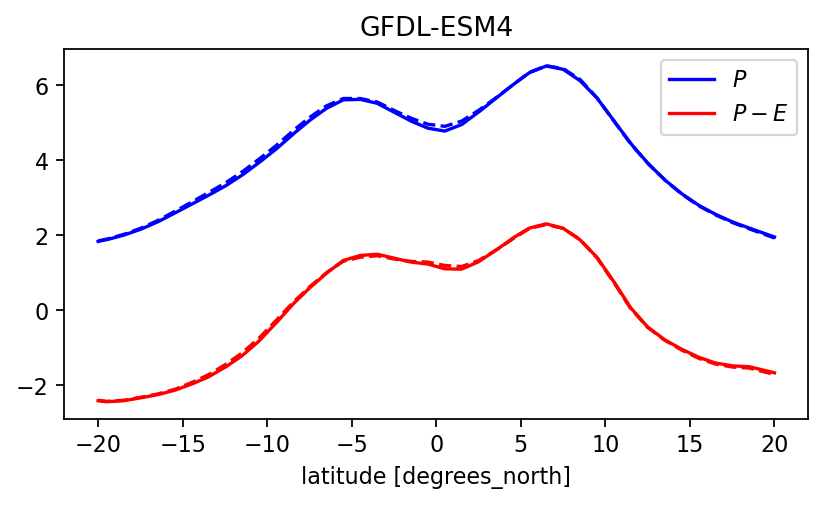

In [20]:
m = 'GFDL-ESM4'
c = '1pctCO2'

fig,ax = plt.subplots(figsize=(6,3))

pr_zm_interp[m]['1pctCO2'].sel(lat=slice(phi_1,phi_2)).mean(dim='time').plot(ax=ax,c='blue',label='$P$')
pr_zm_interp[m]['1pctCO2-rad'].sel(lat=slice(phi_1,phi_2)).mean(dim='time').plot(ax=ax,c='blue',ls='--')

pe_zm_interp[m]['1pctCO2'].sel(lat=slice(phi_1,phi_2)).mean(dim='time').plot(ax=ax,c='red',label='$P-E$')
pe_zm_interp[m]['1pctCO2-rad'].sel(lat=slice(phi_1,phi_2)).mean(dim='time').plot(ax=ax,c='red',ls='--')

ax.set_title(m)
ax.legend()

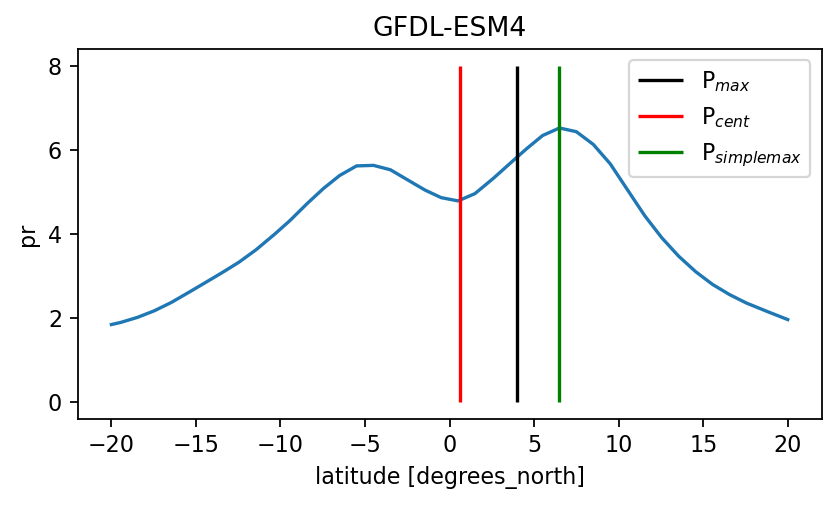

In [21]:
m = 'GFDL-ESM4'
c = '1pctCO2'

fig,ax = plt.subplots(figsize=(6,3))

# for m in models:
pr_zm_interp[m][c].sel(lat=slice(-20.05,20)).mean(dim='time').plot(ax=ax)
ax.vlines(pr_max[m][c],0,8,color='k',label='P$_{max}$')
ax.vlines(pr_centroid[m][c],0,8,color='r',label='P$_{cent}$')
ax.vlines(pr_simplemax[m][c],0,8,color='g',label='P$_{simplemax}$')

# ax.vlines(pe_max[m][c],0,8,color='k',label='$P-E_{max}$')
# ax.vlines(pe_centroid[m][c],0,8,color='r',label='$P-E_{cent}$')
# ax.vlines(pe_simplemax[m][c],0,8,color='g',label='$P-E_{simplemax}$')

ax.set_title(m)
ax.legend()

## LAI and albedo averages

In [22]:
nhigh = slice(40,90)

## Set up dictionaries for storing data
lai_nhigh = {}
alb_nhigh = {}
dfrlai_nhigh = {}

for m in models:
    lai_nhigh[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    alb_nhigh[m] = {'piControl': {}, '1pctCO2': {}, '1pctCO2-rad': {}, '1pctCO2-bgc': {}}
    
    for c in cases_rad:
        lai_nhigh[m][c] = lai_zm[m][c].sel(lat=nhigh).mean(dim=['time','lat']).values
        alb_nhigh[m][c] = alb_zm[m][c].sel(lat=nhigh).mean(dim=['time','lat']).values        
    
    dfrlai_nhigh[m] = dfrlai_zm[m].mean(dim=['time','lat']).values  

# Visualization

## ITCZ latitude vs. LAI

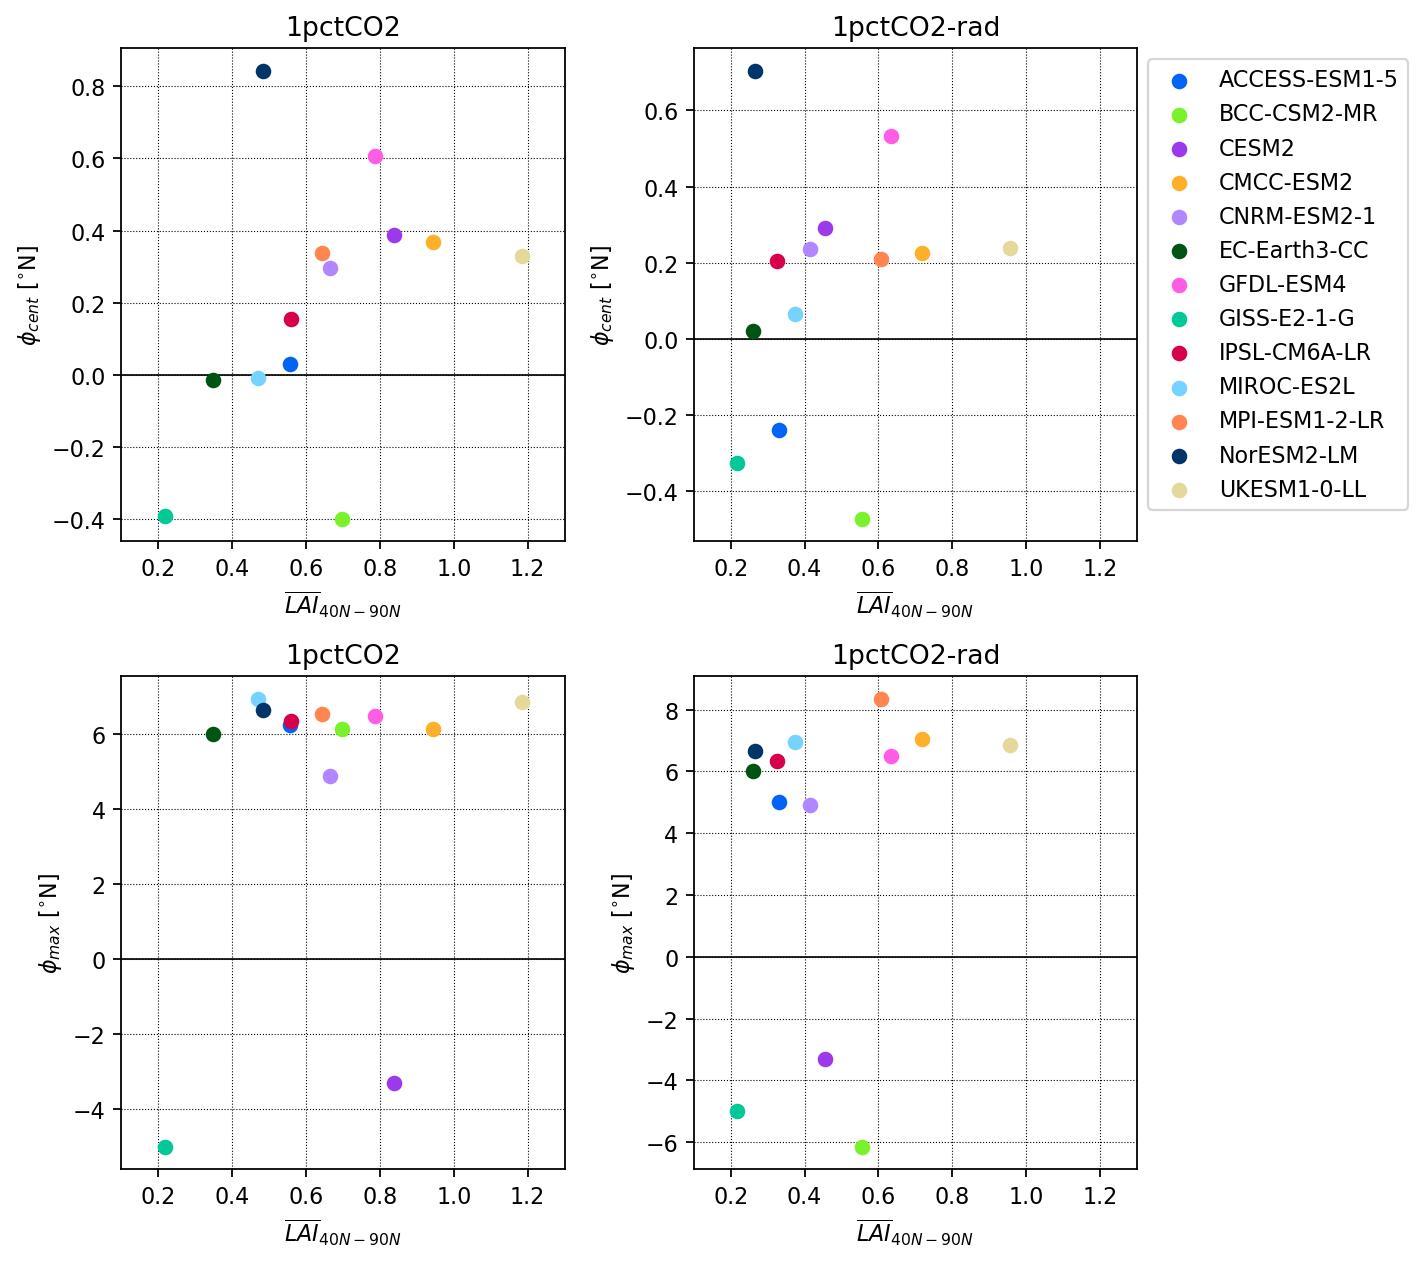

In [23]:
fig,axes = plt.subplots(2,2,figsize=(9,8))
ax = axes.ravel()

for ic,c in enumerate(cases_rad):
    for m in models:
        ax[ic].scatter(lai_nhigh[m][c], pr_centroid[m][c], c=mcolors[m], label=m, zorder=3)
        ax[ic+2].scatter(lai_nhigh[m][c], pr_simplemax[m][c], c=mcolors[m], label=m, zorder=3)

    ax[ic].set_title(c)
    ax[ic].set_ylabel('$\phi_{cent}$ [$^{\circ}$N]')
    ax[ic+2].set_title(c)
    ax[ic+2].set_ylabel('$\phi_{max}$ [$^{\circ}$N]')
    
for a in ax:
    a.set_xlabel('$\overline{LAI}_{40N-90N}$')
    a.set_xlim(0.1,1.3)
    # a.set_ylim(-6,6)
    a.hlines(0,0.1,1.3,color='k',linewidth=0.75,zorder=0)
    a.grid(linewidth=0.5,ls=':',c='k',zorder=0)

ax[1].legend(ncols=1, bbox_to_anchor=[1,1])
fig.tight_layout()

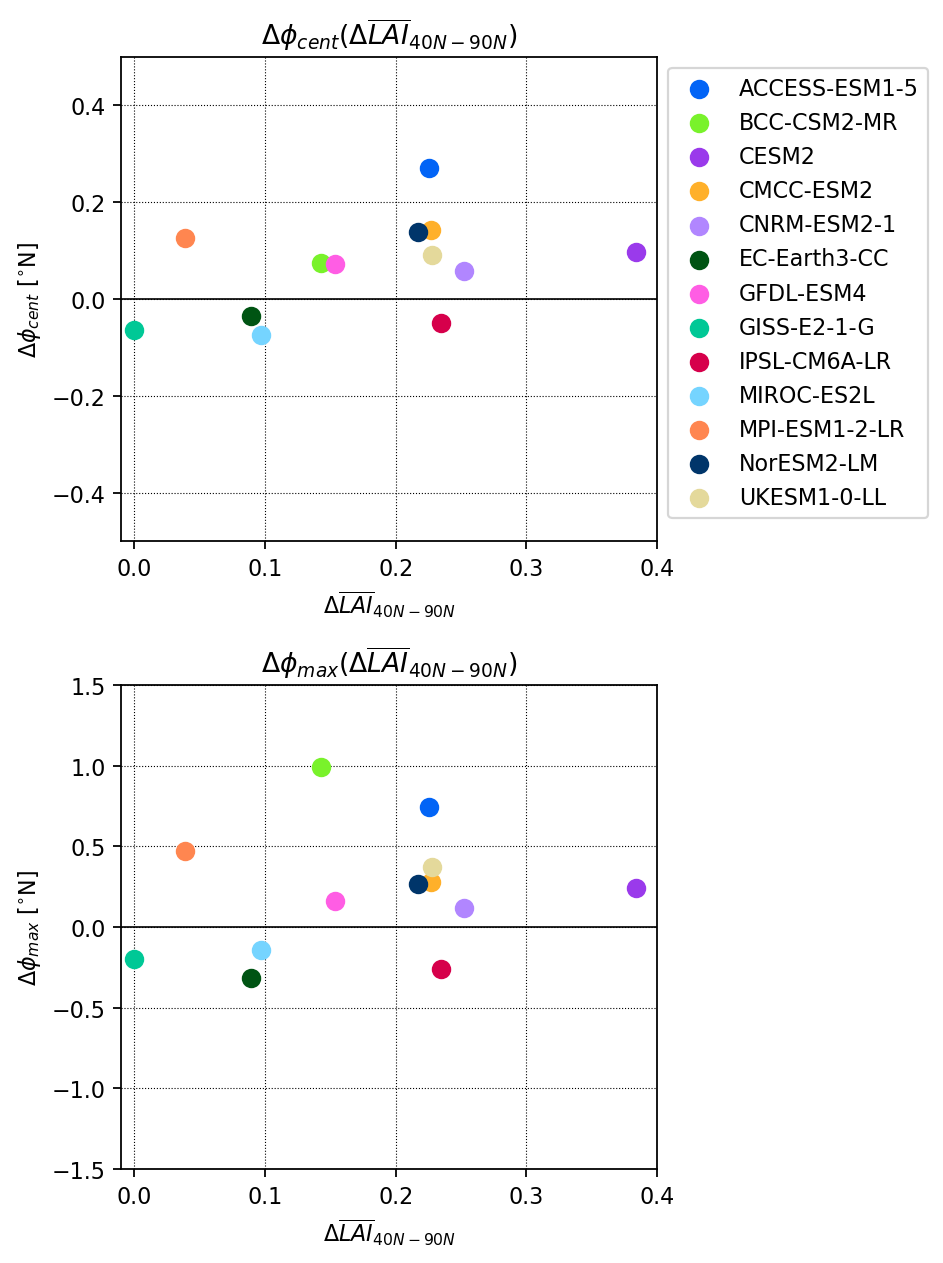

In [60]:
fig,axes = plt.subplots(2,1,figsize=(6,8))
ax = axes.ravel()

ms = 60

for m in models:
    ax[0].scatter(lai_nhigh[m]['1pctCO2']-lai_nhigh[m]['1pctCO2-rad'], pr_centroid[m]['1pctCO2']-pr_centroid[m]['1pctCO2-rad'],
                  c=mcolors[m], s=ms, label=m, zorder=3)
    ax[1].scatter(lai_nhigh[m]['1pctCO2']-lai_nhigh[m]['1pctCO2-rad'], pr_max[m]['1pctCO2']-pr_max[m]['1pctCO2-rad'],
                  c=mcolors[m], s=ms, label=m, zorder=3)

ax[0].set_ylabel('$\Delta\phi_{cent}$ [$^{\circ}$N]')
ax[1].set_ylabel('$\Delta\phi_{max}$ [$^{\circ}$N]')

ax[0].set_ylim(-0.5,0.5)
ax[1].set_ylim(-1.5,1.5)

ax[0].set_title('$\Delta\phi_{cent} (\Delta\overline{LAI}_{40N-90N})$')
ax[1].set_title('$\Delta\phi_{max} (\Delta\overline{LAI}_{40N-90N})$')

for a in ax:
    a.set_xlabel('$\Delta\overline{LAI}_{40N-90N}$')
    a.set_xlim(-0.01,0.4)
    a.hlines(0,-0.01,0.4,color='k',linewidth=0.75,zorder=0)
    a.grid(linewidth=0.5,ls=':',c='k',zorder=0)

ax[0].legend(ncols=1, bbox_to_anchor=[1,1])
fig.tight_layout()

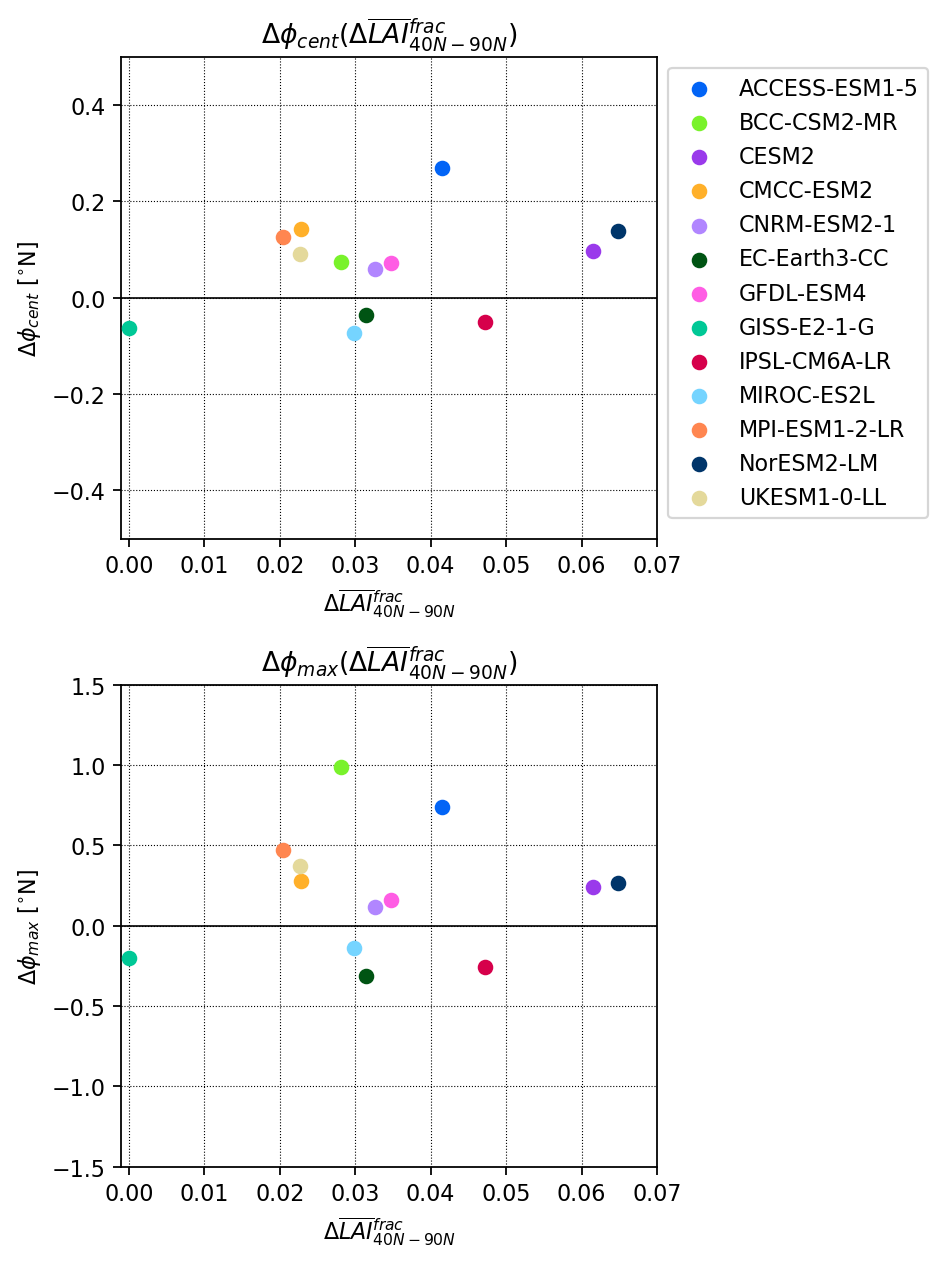

In [45]:
fig,axes = plt.subplots(2,1,figsize=(6,8))
ax = axes.ravel()

for m in models:
    ax[0].scatter(dfrlai_nhigh[m], pr_centroid[m]['1pctCO2']-pr_centroid[m]['1pctCO2-rad'],
                  c=mcolors[m], label=m, zorder=3)
    ax[1].scatter(dfrlai_nhigh[m], pr_max[m]['1pctCO2']-pr_max[m]['1pctCO2-rad'],
                  c=mcolors[m], label=m, zorder=3)

ax[0].set_ylabel('$\Delta\phi_{cent}$ [$^{\circ}$N]')
ax[1].set_ylabel('$\Delta\phi_{max}$ [$^{\circ}$N]')

ax[0].set_ylim(-0.5,0.5)
ax[1].set_ylim(-1.5,1.5)

ax[0].set_title('$\Delta\phi_{cent} (\Delta\overline{LAI}_{40N-90N}^{frac})$')
ax[1].set_title('$\Delta\phi_{max} (\Delta\overline{LAI}_{40N-90N}^{frac})$')

for a in ax:
    a.set_xlabel('$\Delta\overline{LAI}_{40N-90N}^{frac}$')
    a.set_xlim(-0.001,0.07)
    a.hlines(0,-0.01,0.07,color='k',linewidth=0.75,zorder=0)
    a.grid(linewidth=0.5,ls=':',c='k',zorder=0)

ax[0].legend(ncols=1, bbox_to_anchor=[1,1])
fig.tight_layout()

## ITCZ latitude vs. albedo

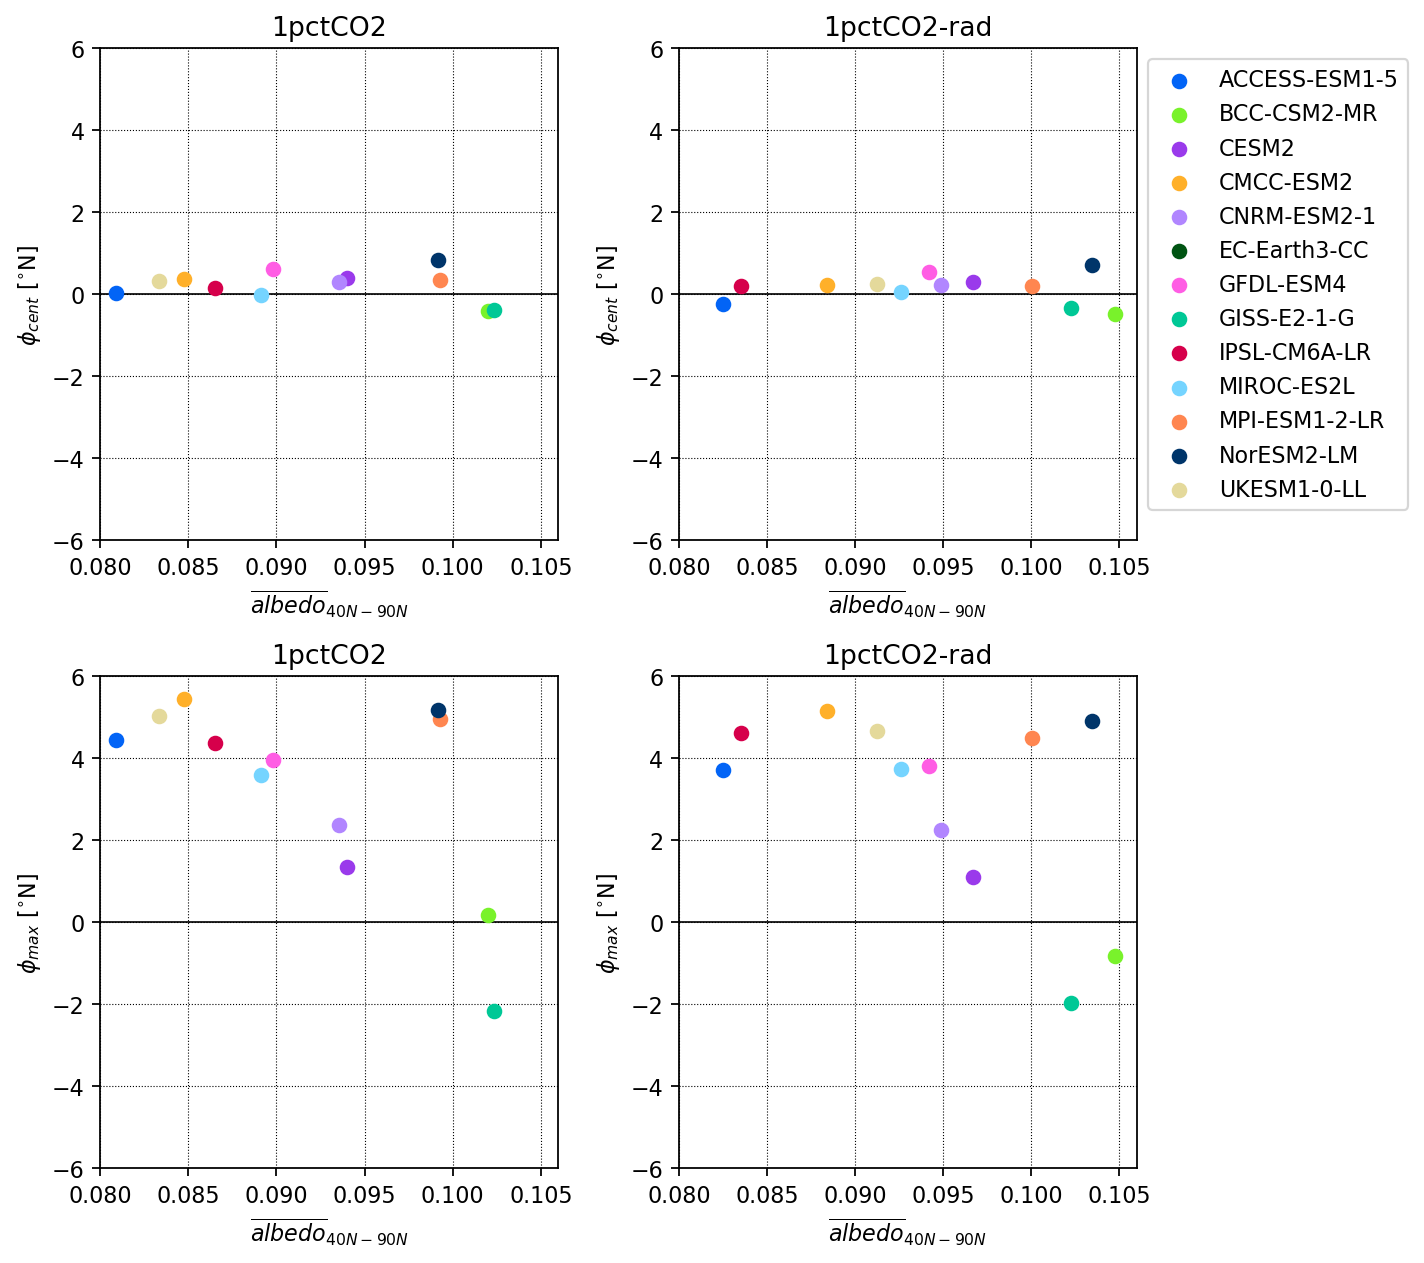

In [26]:
fig,axes = plt.subplots(2,2,figsize=(9,8))
ax = axes.ravel()

for ic,c in enumerate(cases_rad):
    for m in models:
        ax[ic].scatter(alb_nhigh[m][c], pr_centroid[m][c], c=mcolors[m], label=m, zorder=3)
        ax[ic+2].scatter(alb_nhigh[m][c], pr_max[m][c], c=mcolors[m], label=m, zorder=3)

    ax[ic].set_title(c)
    ax[ic].set_ylabel('$\phi_{cent}$ [$^{\circ}$N]')
    ax[ic+2].set_title(c)
    ax[ic+2].set_ylabel('$\phi_{max}$ [$^{\circ}$N]')
    
for a in ax:
    a.set_xlabel('$\overline{albedo}_{40N-90N}$')
    a.set_xlim(0.08,0.106)
    a.set_ylim(-6,6)
    a.hlines(0,0.08,0.106,color='k',linewidth=0.75,zorder=0)
    a.grid(linewidth=0.5,ls=':',c='k',zorder=0)

ax[1].legend(ncols=1, bbox_to_anchor=[1,1])
fig.tight_layout()

/tmp/ipykernel_226166/1551149564.py:7: RuntimeWarning: invalid value encountered in subtract
  ax[0].scatter(alb_nhigh[m]['1pctCO2']-alb_nhigh[m]['1pctCO2-rad'], pr_centroid[m]['1pctCO2']-pr_centroid[m]['1pctCO2-rad'],
/tmp/ipykernel_226166/1551149564.py:9: RuntimeWarning: invalid value encountered in subtract
  ax[1].scatter(alb_nhigh[m]['1pctCO2']-alb_nhigh[m]['1pctCO2-rad'], pr_max[m]['1pctCO2']-pr_max[m]['1pctCO2-rad'],


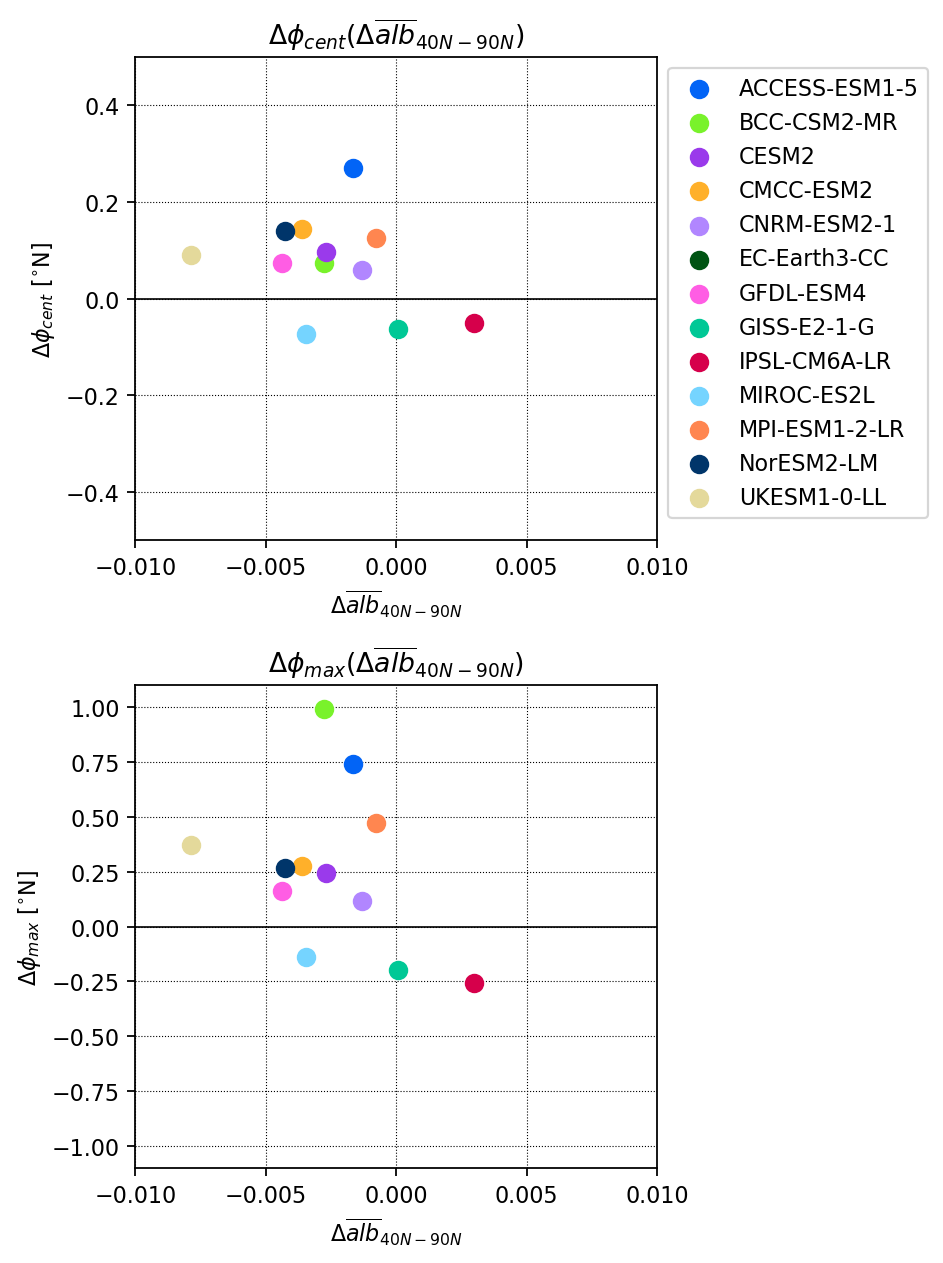

In [61]:
fig,axes = plt.subplots(2,1,figsize=(6,8))
ax = axes.ravel()

ms = 60

for m in models:
    ax[0].scatter(alb_nhigh[m]['1pctCO2']-alb_nhigh[m]['1pctCO2-rad'], pr_centroid[m]['1pctCO2']-pr_centroid[m]['1pctCO2-rad'],
                  c=mcolors[m], label=m, s=ms, zorder=3)
    ax[1].scatter(alb_nhigh[m]['1pctCO2']-alb_nhigh[m]['1pctCO2-rad'], pr_max[m]['1pctCO2']-pr_max[m]['1pctCO2-rad'],
                  c=mcolors[m], label=m, s=ms, zorder=3)

ax[0].set_ylabel('$\Delta\phi_{cent}$ [$^{\circ}$N]')
ax[1].set_ylabel('$\Delta\phi_{max}$ [$^{\circ}$N]')

ax[0].set_ylim(-0.5,0.5)
ax[1].set_ylim(-1.1,1.1)

ax[0].set_title('$\Delta\phi_{cent}(\Delta\overline{alb}_{40N-90N})$')
ax[1].set_title('$\Delta\phi_{max}(\Delta\overline{alb}_{40N-90N})$')

for a in ax:
    a.set_xlabel('$\Delta\overline{alb}_{40N-90N}$')
    a.set_xlim(-0.01,0.01)
    a.hlines(0,-0.01,0.01,color='k',linewidth=0.75,zorder=0)
    a.grid(linewidth=0.5,ls=':',c='k',zorder=0)

ax[0].legend(ncols=1, bbox_to_anchor=[1,1])
fig.tight_layout()

# Get data

```CMIPnht/MPI-ESM1-2-LR/storagemoist_Amon_MPI-ESM1-2-LR_1pctCO2-rad_r1i1p1f1_zonal_195001-198912.nc```

In [25]:
def gettimeslice(m, c):
    if c == 'piControl':
        st = period_l40_start_year_in_pi[m].replace('-','')
        et = period_l40_end_year_in_pi[m].replace('-','')
        time = st+'-'+et
    elif c[:7] == '1pctCO2':
        st = period_l40_start_year_in_co2[m].replace('-','')
        et = period_l40_end_year_in_co2[m].replace('-','')
        time = st+'-'+et
    else:
        time = ''
    return time

In [26]:
def getnht(v, m, c):
    tslice = gettimeslice(m, c)
    path = cmipnhtdir+m+'/'+v+'_Amon_'+m+'_'+c+'_'+variant_id[m]+'_zonal_'+tslice+'.nc'
    return xr.open_dataset(path)[v]

In [21]:
ht = {}
for v in variables_nht:
    ht[v] = {}
    for m in models:
        ht[v][m] = {}
        for c in cases_rad:
            ht[v][m][c] = getnht(v, m, c)

/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/core/indexing.py:529: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itc